In [56]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt

In [57]:
def trim(im) :
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im,bg)
    diff = PIL.ImageChops.add(diff,diff,2.0,-20)
    bbox = diff.getbbox()
    if bbox :
        return im.crop(bbox)

def img_preprocessing(img) :
    img = trim(img)
    img = img.resize(128,128)
    img = img.convert('L')
    
## 위에 과정은 resize, gray scale 사용할거면 필요 없음. 
## 이미지 전처리하는 과정인데 전처리해서 grayscale로 만들지를 않음. 

In [58]:
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(3)

#1 데이터 전처리 -> ImageDataGenerator 사용! 
train_datagen = ImageDataGenerator(rescale=1./255)  
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('retinopathy_dataset_resize_gray/train',
                                                 target_size = (128,128),
                                                 batch_size = 64,
                                                 class_mode = 'binary')

test_generator = test_datagen.flow_from_directory('retinopathy_dataset_resize_gray/test',
                                            target_size = (128,128),
                                            batch_size = 64,
                                            class_mode = 'binary')

Found 1230 images belonging to 2 classes.
Found 292 images belonging to 2 classes.


In [72]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
import numpy as np


model = Sequential()
model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2))) #(64,64)
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(32,32)
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(16,16)
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(8,8)
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #(4,4)
model.add(Flatten())
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid')) 
# sigmoid로 간 이유 https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function/
# softmax로 가면 loss funcion에서 문제가 생김. 




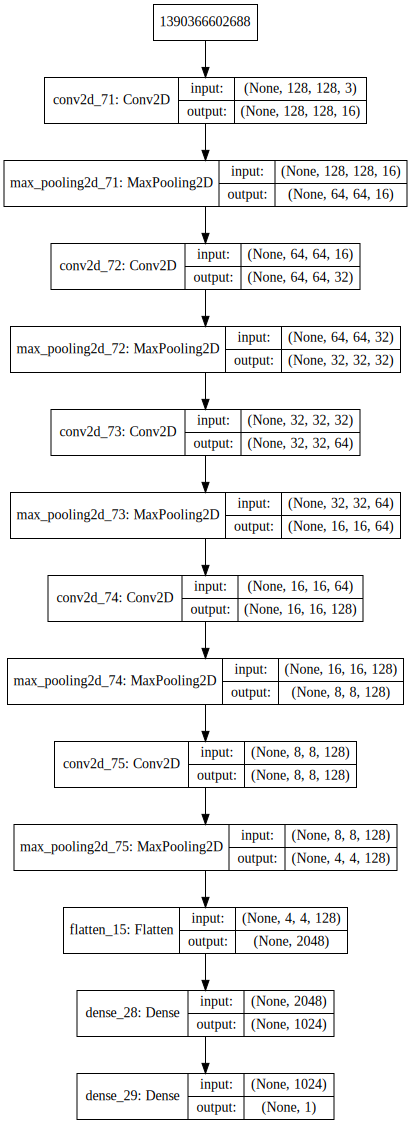

In [60]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [77]:
#모델 학습과정 설정 및 모델 학습
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist= model.fit_generator(
        train_generator,
        steps_per_epoch=20,#1230 data에 batch_size=64 1230/64=19.21875 ->20
        epochs=10, # 최적화를 위해 5번의 epoch를 10번으로 늘림. 
        validation_data=test_generator,
        validation_steps=5) #292 data의 batch_size 64 292/64 =4.5625 -> 5

Epoch 1/10
20/20 [==============================] - 35s 2s/step - loss: 0.6806 - acc: 0.5866 - val_loss: 0.6919 - val_acc: 0.5479
Epoch 2/10
20/20 [==============================] - 34s 2s/step - loss: 0.6718 - acc: 0.5913 - val_loss: 0.6685 - val_acc: 0.6164
Epoch 3/10
20/20 [==============================] - 34s 2s/step - loss: 0.6514 - acc: 0.6330 - val_loss: 0.6355 - val_acc: 0.6507
Epoch 4/10
20/20 [==============================] - 33s 2s/step - loss: 0.6400 - acc: 0.6431 - val_loss: 0.6569 - val_acc: 0.5959
Epoch 5/10
20/20 [==============================] - 33s 2s/step - loss: 0.6360 - acc: 0.6453 - val_loss: 0.6412 - val_acc: 0.6644
Epoch 6/10
20/20 [==============================] - 32s 2s/step - loss: 0.6076 - acc: 0.6683 - val_loss: 0.6374 - val_acc: 0.6610
Epoch 7/10
20/20 [==============================] - 32s 2s/step - loss: 0.6076 - acc: 0.6767 - val_loss: 0.5900 - val_acc: 0.7295
Epoch 8/10
20/20 [==============================] - 32s 2s/step - loss: 0.5671 - acc: 0.72

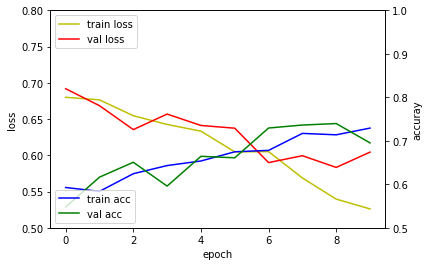

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.5, 0.8])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.5, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [79]:
# 모델 평가하기
print("-- Evaluate --")
test_pred = model.evaluate_generator(test_generator, steps=5)
print("%s: %.2f%%" %(model.metrics_names[1], test_pred[1]*100))

-- Evaluate --
acc: 69.52%


In [80]:
# 모델 사용하기
print("-- Predict --")
output = model.predict_generator(test_generator, steps=5)
print(test_generator.class_indices)
print(output)

-- Predict --
{'0': 0, '1': 1}
[[0.293]
 [0.207]
 [0.439]
 [0.421]
 [0.525]
 [0.883]
 [0.422]
 [0.011]
 [0.969]
 [0.084]
 [0.131]
 [0.155]
 [0.885]
 [0.514]
 [0.842]
 [0.156]
 [0.099]
 [0.502]
 [0.869]
 [0.612]
 [0.324]
 [0.736]
 [0.323]
 [0.217]
 [0.132]
 [0.542]
 [0.266]
 [0.688]
 [0.963]
 [0.452]
 [0.435]
 [0.705]
 [0.719]
 [0.082]
 [0.427]
 [0.775]
 [0.711]
 [0.063]
 [0.664]
 [0.188]
 [0.408]
 [0.402]
 [0.657]
 [0.165]
 [0.342]
 [0.480]
 [0.826]
 [0.195]
 [0.471]
 [0.030]
 [0.168]
 [0.935]
 [0.292]
 [0.196]
 [0.146]
 [0.907]
 [0.740]
 [0.223]
 [0.249]
 [0.035]
 [0.256]
 [0.551]
 [0.698]
 [0.216]
 [0.205]
 [0.510]
 [0.503]
 [0.852]
 [0.353]
 [0.202]
 [0.473]
 [0.523]
 [0.161]
 [0.984]
 [0.315]
 [0.241]
 [0.733]
 [0.293]
 [0.526]
 [0.706]
 [0.393]
 [0.180]
 [0.250]
 [0.727]
 [0.117]
 [0.739]
 [0.701]
 [0.040]
 [0.652]
 [0.174]
 [0.527]
 [0.509]
 [0.222]
 [0.454]
 [0.136]
 [0.700]
 [0.370]
 [0.310]
 [0.409]
 [0.943]
 [0.543]
 [0.187]
 [0.016]
 [0.163]
 [0.495]
 [0.986]
 [0.054]
 [0.64